In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats as st
from math import comb
from matplotlib import cm, colors, rc
from read_data import DataAnalysis
from scipy.spatial.distance import mahalanobis as mh
from statsmodels.distributions.empirical_distribution import ECDF

%matplotlib inline
rc('text', usetex=True)

folder_fig = "figs"
dir_fig = lambda x: os.path.join(folder_fig, x)
np.random.seed(43)

def set_size(w, h, ax):
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

In [8]:
# Read file
file = open("data.txt").readlines()
file = list(map(lambda x: x.replace("\n", "").split("\t"), file))

temperatures = np.array(file, dtype=float)

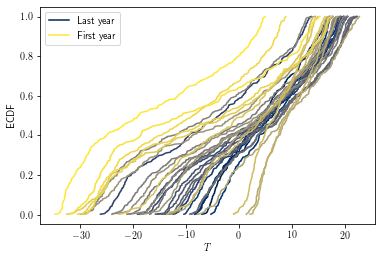

In [9]:
# First point 35 years
color1 = plt.get_cmap('cividis')
color_norm = colors.Normalize(vmin=0, vmax=temperatures.shape[1] - 1)
scalar_map = cm.ScalarMappable(norm=color_norm, cmap=color1)
legends = {0: 'Last year', temperatures.shape[1] - 1: 'First year'}
ecdfs = []
for i in range(temperatures.shape[1]):
    color = scalar_map.to_rgba(i)
    ecdf = ECDF(temperatures[:, i])
    ecdfs.append(ecdf)
    if i in legends.keys():
        plt.plot(ecdf.x, ecdf.y, color=color, label=legends[i])
    else:
        plt.plot(ecdf.x, ecdf.y, color=color)
plt.legend()
plt.xlabel("$T$")
plt.ylabel("ECDF")
plt.savefig(dir_fig("ecdfs.pdf"), bbox_inches='tight')
plt.show()

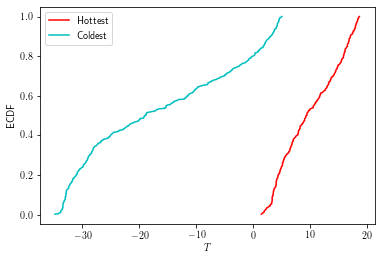

In [10]:
# Plot hottest and coldest, in average.
means = temperatures.mean(axis=0)
index_max = means.argmax()
index_min = means.argmin()

ecdf_max = ecdfs[index_max]
ecdf_min = ecdfs[index_min]

plt.plot(ecdf_max.x, ecdf_max.y, 'r', label='Hottest')
plt.plot(ecdf_min.x, ecdf_min.y, 'c', label='Coldest')
plt.legend()
plt.xlabel("$T$")
plt.ylabel("ECDF")
plt.savefig(dir_fig("ecdfs_extremes.pdf"), bbox_inches='tight')
plt.show()

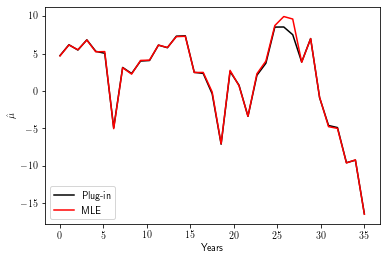

In [12]:
# Calculate area
plug_in_means = []
for i in range(temperatures.shape[1]):
    ecdf = ecdfs[i]
    index_positive = np.where(ecdf.x == ecdf.x[ecdf.x >= 0][0])[0][0]
    
    positive = ecdf.y[index_positive:]
    negative = ecdf.y[:index_positive]
    
    area_positive = 0
    for j in range(len(positive) - 1):
        area_positive += (ecdf.x[j + 1 + index_positive] - ecdf.x[j + index_positive]) * (1 - positive[j])
    
    area_negative = 0
    for j in range(1, len(negative) - 1):
        area_negative += (ecdf.x[j + 1] - ecdf.x[j]) * negative[j]
    
    plug_in_means.append(area_positive - area_negative)

means_estimated = temperatures.mean(axis = 0)
years = np.linspace(0, temperatures.shape[1], temperatures.shape[1])
plt.plot(years, plug_in_means, 'k', label='Plug-in')
plt.plot(years, means_estimated, 'r', label='MLE')
plt.legend()
plt.xlabel("Years")
plt.ylabel("$\hat{\mu}$")
plt.savefig(dir_fig("means.pdf"), bbox_inches='tight')
plt.show()

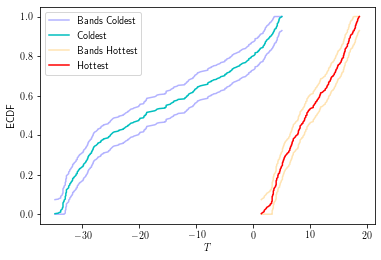

In [13]:
### Bandwidths for hottest and coldest year
alpha = 0.05
epsilon = np.sqrt(1 / (2 * temperatures.shape[0]) * np.log(2 / alpha))

def bands(ecdf):
    lower = np.zeros(len(ecdf.y))
    upper = np.zeros(len(ecdf.y))
    for i in range(len(ecdf.y)):
        lower[i] = max(ecdf.y[i] - epsilon, 0)
        upper[i] = min(ecdf.y[i] + epsilon, 1)
    return lower, upper

lower_cold, upper_cold = bands(ecdf_min)
lower_hot, upper_hot = bands(ecdf_max)

# Plotting cold
plt.plot(ecdf_min.x, lower_cold, 'b', alpha=0.3)
plt.plot(ecdf_min.x, upper_cold, 'b', alpha=0.3, label='Bands Coldest')
plt.plot(ecdf_min.x, ecdf_min.y, 'c', label='Coldest')

# Plotting hot
plt.plot(ecdf_max.x, lower_cold, 'orange', alpha=0.3)
plt.plot(ecdf_max.x, upper_cold, 'orange', alpha=0.3, label='Bands Hottest')
plt.plot(ecdf_max.x, ecdf_max.y, 'r', label='Hottest')

plt.legend()
plt.xlabel("$T$")
plt.ylabel("ECDF")
plt.savefig(dir_fig("ecdf_bands.pdf"), bbox_inches='tight')
plt.show()

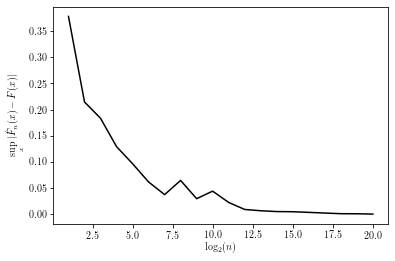

In [14]:
# Weibull simulation
np.random.seed(1234)
nums = np.linspace(1, 20, 20)
data_num = np.exp2(nums).astype(int)
params = [1.5, 0, 1]

differences = []
for i in range(len(data_num)):
    data = st.weibull_max.rvs(*params, size=data_num[i])
    ecdf = ECDF(data)
    real_weibull = st.weibull_max.cdf(ecdf.x, *params)
    
    difference = np.absolute(real_weibull - ecdf.y)
    differences.append(difference.max())

plt.plot(nums, differences, 'k')
plt.xlabel("$\log_2(n)$")
plt.ylabel("$$\sup_x  \,|\hat{F}_n(x) - F(x)|$$")
plt.savefig(dir_fig("weibull.pdf"), bbox_inches='tight')
plt.show()

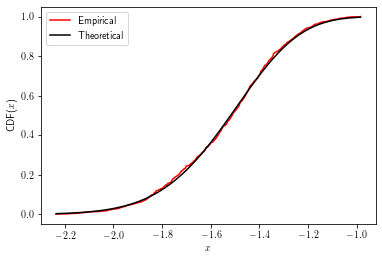

In [15]:
# Order statistic
j = 5
n = 30
params = [1.5, 0, 1]
sims = st.weibull_max.rvs(*params, size=(1000, n))

# Data for order statistic
xj = np.sort(sims, axis=1)[:, j - 1]

# Theoretical function
f_we = lambda x: st.weibull_max.cdf(x, *params)
f_th = lambda x: sum([comb(n, jp) * f_we(x) ** jp * (1 - f_we(x)) ** (n - jp) for jp in range(j, n + 1)])
ecdf = ECDF(xj)
ys_th = list(map(lambda x: f_th(x), ecdf.x[1:]))

# Plotting
plt.plot(ecdf.x, ecdf.y, 'r', label='Empirical')
plt.plot(ecdf.x[1:], ys_th, 'k', label='Theoretical')
plt.legend()
plt.xlabel("$x$")
plt.ylabel("CDF($x$)")
plt.savefig(dir_fig("order.pdf"), bbox_inches='tight')
plt.show()

In [16]:
# Bootstrap method
def bootstrap(series, n, statistic, alpha=0.05, method=0):
    stats = []
    for i in range(n):
        stats.append(statistic(np.random.choice(series, size=len(series))))
    stats = np.array(stats)
    og = statistic(series)
    add = {}
    
    if method == 0:
        aux = (stats - np.mean(stats)) ** 2
        v_boot = 1 / len(stats) * aux.sum()
        z_alpha = st.norm.ppf(1 - alpha / 2)
        interval = (og - z_alpha*np.sqrt(v_boot), og + z_alpha*np.sqrt(v_boot))
        
        add['vboot'] = v_boot
    else:
        theta_alpha_inf = np.quantile(stats, (1 - alpha / 2))
        theta_alpha_sup = np.quantile(stats, alpha / 2)
        interval = (2*og - theta_alpha_inf, 2*og - theta_alpha_sup)
        
    return interval, add

temperatures_max = temperatures[:, index_max]
n = 1000
statistic = lambda x: x.max()
interval, _ = bootstrap(temperatures_max, n, statistic, method=0)
print("Bootstrap interval", interval)
print("Max temperature", statistic(temperatures_max))

Bootstrap interval (18.48448659978916, 18.715513400210842)
Max temperature 18.6


In [17]:
# JackKnife method
def jackknife_bias(series, stastistic):
    og = statistic(series)
    stats = []
    for i in range(len(series)):
        t_i = np.concatenate((series[:i], series[(i+1):]))
        stats.append(statistic(t_i))
    
    t_m = np.mean(stats)
    b_jack = (len(series) - 1) * (t_m - og)
    return b_jack

def jackknife_var(series, statistic):
    og = statistic(series)
    stats = []
    for i in range(len(series)):
        t_i = np.concatenate((series[:i], series[(i+1):]))
        stats.append(statistic(t_i))
    
    ti_v = len(series) * og - (len(series) - 1) * stats
    s2 = ti_v.var(ddof=1)
    
    return s2 / len(series)

b_jack = jackknife_bias(temperatures_max, statistic)
print("Bias:", b_jack)

v_jack = jackknife_var(temperatures_max, statistic)
print("Variance:", v_jack)

Bias: -0.09972602739917136
Variance: 7.485590393207431e-08


In [18]:
# Uniform thingy
def error(the, est):
    return abs((the - est) / the) * 100

n = 10000
sample = np.random.random(size=n)
statistic = lambda x: x.max()

theoretical_bias = -1 / (n + 1)

_, additional = bootstrap(sample, 1000, statistic)
vboot = additional['vboot']
print(vboot)

bias_jack = jackknife_bias(sample, statistic)

print()
print("Theoretical", theoretical_bias)
print("Jackknife", bias_jack)
print(error(theoretical_bias, bias_jack))

3.23610715850085e-10

Theoretical -9.999000099990002e-05
Jackknife -1.3199880013026188e-05
86.79879999897251


In [19]:
### Mahalanobis distance methods
def mahal(u, v, inv_matrix, filename=None, method=0, plot=False, dist='chi2', ax=None):
    distance = []
    
    if method == 0:
        # Parametric
        for i in range(u.shape[1]):
            distance.append(mh(u[:, i], v, inv_matrix))
        distance = np.array(distance)

    # Comparison with Chi Square density
    distribution = getattr(st, dist)
    params = distribution.fit(distance)

    if plot:
        xs = np.linspace(distribution.ppf(0.01, *params), distribution.ppf(0.99, *params), 500)
        if filename is not None:
            plt.hist(distance, color='w', ec='black', density=True)
            plt.plot(xs, distribution.pdf(xs, *params), 'r')
            plt.savefig(dir_fig(filename), bbox_inches='tight')
        else:
            if ax is None:
                plt.hist(distance, color='w', ec='black', density=True)
                plt.plot(xs, distribution.pdf(xs, *params), 'r')
                plt.show()
            else:
                ax.hist(distance, color='w', ec='black', density=True)
                ax.plot(xs, distribution.pdf(xs, *params), 'r')
    return distance

def remove_outliers(data, distance, filename=None, dist='chi2', alpha=0.05, plot=False, ax=None):
    distribution = getattr(st, dist)
    params = distribution.fit(distance)
    
    maximum_distance = distribution.ppf(1 - alpha/2, *params)
    minimum_distance = distribution.ppf(alpha/2, *params)

    outliers_max = data[:, distance > maximum_distance]
    outliers_min = data[:, distance < minimum_distance]
    
    removed_outliers = data[:, distance <= maximum_distance]
    removed_outliers = removed_outliers[:, distance[distance <= maximum_distance] >= minimum_distance]
    
    aux = []
    for i in range(outliers_min.shape[0]):
        aux.append(np.hstack((outliers_max[i, :], outliers_min[i, :])))
    outliers = np.array(aux)
    if plot:
        if filename is not None:
            plt.scatter(data[0, :], data[1, :], color='k', s=5)
            plt.scatter(outliers[0, :], outliers[1, :], color='r', s=5)
            plt.savefig(dir_fig(filename), bbox_inches='tight')
        else:
            if ax is None:
                plt.scatter(data[0, :], data[1, :], color='k', s=5)
                plt.scatter(outliers[0, :], outliers[1, :], color='r', s=5)
                plt.show()
            else:
                ax.scatter(data[0, :], data[1, :], c='k', s=5)
                ax.scatter(outliers[0, :], outliers[1, :], c='r', s=5)
    return removed_outliers, outliers

sample = np.vstack((temperatures[:, index_min], temperatures[:, index_max]))

<Figure size 432x288 with 0 Axes>

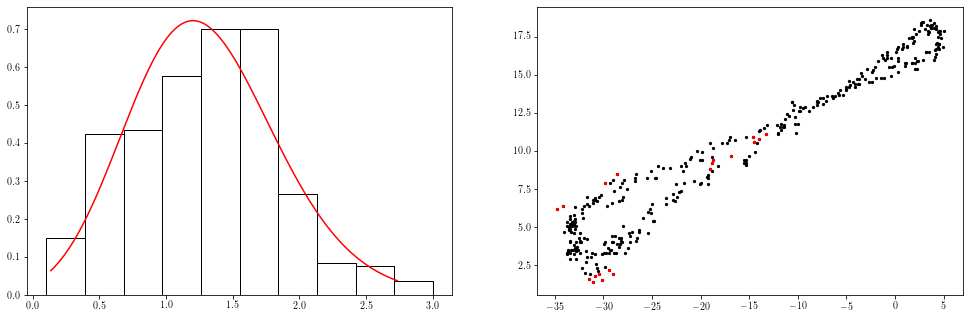

In [25]:
# Non-robust
def non_robust(sample, filename=None):
    inv_cov = np.linalg.inv(np.cov(sample))
    means = sample.mean(axis=1)
    if filename is not None:
        fn = "non_robust_hist_" + filename
        distance = mahal(sample, means, inv_cov, plot=True,filename=fn)
        fn = "non_robust_scatter_" + filename
        remove_outliers(sample, distance, plot=True, filename=fn)
        plt.clf()
    
    _, (ax1, ax2) = plt.subplots(1, 2)
    set_size(13, 4, ax1)
    set_size(13, 4, ax2)
    distance = mahal(sample, means, inv_cov, plot=True, ax=ax1)
    removed_outliers, outliers = remove_outliers(sample, distance, plot=True, ax=ax2)
    plt.show()
    

non_robust(sample, filename="no-noise.pdf")

1. ncf          DO NOT REJECT
		P-value for test 0.2622476253486476
		Parameters       [0.01687548831480742, 17.239695538286078, 26.541605824072157, -0.16212434800608705, 0.026204105994287116]
1. powerlognorm DO NOT REJECT
		P-value for test 0.3936884169525032
		Parameters       [543.7709069217824, 0.6214705751743547, -0.9375471875010688, 13.662467507857233]
1. loggamma     DO NOT REJECT
		P-value for test 0.2880282532467704
		Parameters       [20.07659805815092, -4.88556187496933, 1.9903081462053662]


<Figure size 432x288 with 0 Axes>

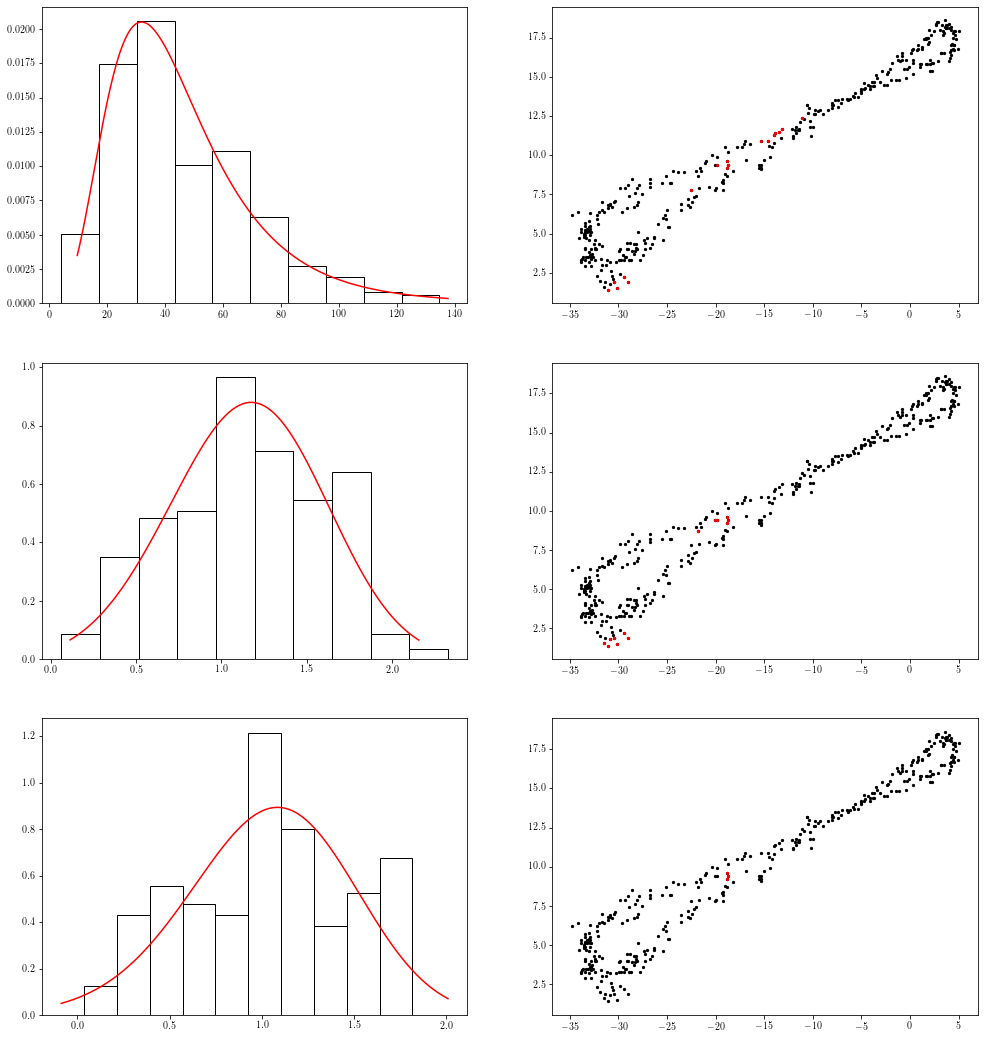

In [30]:
def corr_to_cov(data, correlation):
    var = data.std(axis=1, ddof=1)
    cov = np.zeros(correlation.shape)
    for i in range(correlation.shape[0]):
        for j in range(correlation.shape[1]):
            cov[i, j] = correlation[i, j] * var[i] * var[j]
    return cov

def analysis_outliers(sample, dist1='chi2', dist2='genlogistic', dist3='genlogistic', filename=None):
    da = DataAnalysis()
    ### Robust
    # Median
    medians = np.quantile(sample, 0.5, axis=1)

    # Calculate Co-median
    inv_com = np.zeros((medians.size, medians.size))
    for i in range(sample.shape[0]):
        for j in range(medians.size):
            diff = np.multiply(sample[i, :] - medians[i], sample[j, :] - medians[j])
            inv_com[i, j] = np.quantile(diff, 0.5)
            
    inv_com = np.linalg.inv(inv_com / (sample.shape[1] - 1))
    
    # Calculate Spearman
    spearman = pd.DataFrame(sample.transpose()).corr(method="spearman").to_numpy()
    cov_sp = corr_to_cov(sample, spearman)
    
    # Calculate Kendall
    kendall = pd.DataFrame(sample.transpose()).corr(method="kendall").to_numpy()
    cov_k = corr_to_cov(sample, kendall)
    
    if filename is not None:
        fn = "comedian_hist_" + filename
        distance = mahal(sample, medians, inv_com, plot=True, dist=dist1, filename=fn)
        fn = "comedian_scatter_" + filename
        remove_outliers(sample, distance, plot=True, dist=dist1, filename=fn)
        plt.clf()
        
        fn = "spearman_hist_" + filename
        distance = mahal(sample, medians, np.linalg.inv(cov_sp), plot=True, dist=dist2, filename=fn)
        fn = "spearman_scatter_" + filename
        remove_outliers(sample, distance, plot=True, dist=dist2, filename=fn)
        plt.clf()
        
        fn = "kendall_hist_" + filename
        distance = mahal(sample, medians, np.linalg.inv(cov_k), plot=True, dist=dist3, filename=fn)
        fn = "kendall_scatter_" + filename
        remove_outliers(sample, distance, plot=True, dist=dist3, filename=fn)
        plt.clf()
    
    _, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
    set_size(13, 14, ax1)
    set_size(13, 14, ax2)
    set_size(13, 14, ax3)
    set_size(13, 14, ax4)
    set_size(13, 14, ax5)
    set_size(13, 14, ax6)

    distance = mahal(sample, medians, inv_com, plot=True, ax=ax1, dist=dist1)
    da.set_data(distance)
    da.fitting_test(rank=1, show=True)
    removed_outliers, outliers = remove_outliers(sample, distance, plot=True, ax=ax2, dist=dist1)

    # Spearman
    distance = mahal(sample, medians, np.linalg.inv(cov_sp), plot=True, ax=ax3, dist=dist2)
    da.set_data(distance)
    da.fitting_test(rank=1, show=True)
    removed_outliers, outliers = remove_outliers(sample, distance, plot=True, ax=ax4, dist=dist2)
    
    # kendall
    distance = mahal(sample, medians, np.linalg.inv(cov_k), plot=True, ax=ax5, dist=dist3)
    da.set_data(distance)
    da.fitting_test(rank=1, show=True)
    removed_outliers, outliers = remove_outliers(sample, distance, plot=True, dist=dist3, ax=ax6)

analysis_outliers(sample, dist1='ncf', dist2='powerlognorm', dist3='loggamma', filename="no-noise.pdf")

In [32]:
# Damage data
damaged_sample = sample.copy()
indexes = np.random.randint(sample.shape[1] - 1, size=30)
for index in indexes:
    rand = np.random.random()
    if rand < 0.5:
        damaged_sample[0, index] += np.random.normal(10, 0.5)
    else:
        damaged_sample[1, index] += np.random.normal(10, 0.5)

<Figure size 432x288 with 0 Axes>

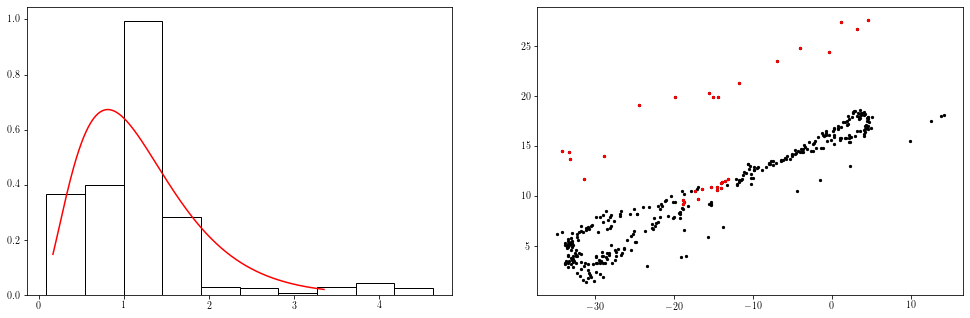

In [50]:
# Create outliers
non_robust(damaged_sample, filename="with-noise.pdf")

1. johnsonsu    DO NOT REJECT
		P-value for test 0.6172422707282684
		Parameters       [-0.8709236004150269, 0.8400178936597636, 22.46474687568135, 8.954005228686317]
1. dgamma       DO NOT REJECT
		P-value for test 0.1400114240556881
		Parameters       [0.803507647588517, 1.087746466932367, 0.5675957152726098]
1. gennorm      DO NOT REJECT
		P-value for test 0.5291286049278067
		Parameters       [1.1075351978441532, 1.060235437415685, 0.4783704628901324]


<Figure size 432x288 with 0 Axes>

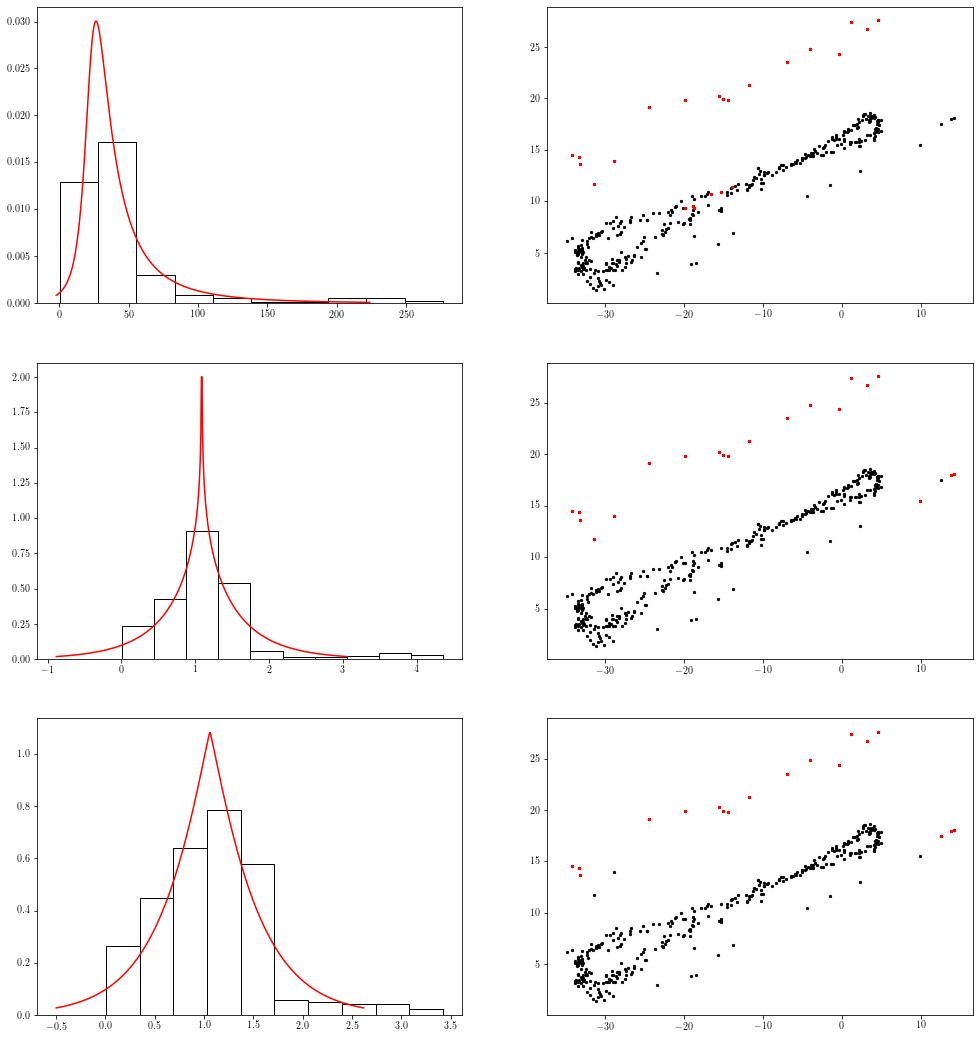

In [35]:
analysis_outliers(damaged_sample, dist1='johnsonsu', dist2='dgamma', dist3='gennorm',  \
                  filename="with-noise.pdf")

In [45]:
# Generation of Bernoulli Data
power = list(range(3, 16))
ns = [2**i for i in power]
bns = []
for n in ns:
    bns.append(st.bernoulli.rvs(0.2, size=n))

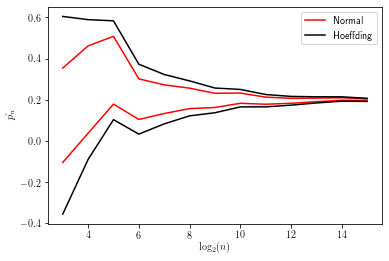

In [49]:
# Analysis
alpha = 0.05
z_alpha = st.norm.ppf(1 - alpha / 2)

# Finding bands
lower = []
upper = []

lower_alt = []
upper_alt = []
for bn in bns:
    p_hat = bn.mean()
    upper.append(p_hat + z_alpha * np.sqrt((p_hat * (1 - p_hat) / len(bn))))
    lower.append(p_hat - z_alpha * np.sqrt((p_hat * (1 - p_hat) / len(bn))))
    
    upper_alt.append(p_hat + np.sqrt(np.log(2 / alpha) / (2 * len(bn))))
    lower_alt.append(p_hat - np.sqrt(np.log(2 / alpha) / (2 * len(bn))))

# Plotting bands
plt.plot(power, upper, 'r')
plt.plot(power, lower, 'r', label="Normal")

plt.plot(power, upper_alt, 'k')
plt.plot(power, lower_alt, 'k', label="Hoeffding")
plt.legend()
plt.xlabel("$\log_2(n)$")
plt.ylabel("$\hat{p_n}$")

plt.savefig(dir_fig("bernoulli_bands.pdf"), bbox_inches='tight')
plt.show()

In [53]:
# Generate normal observation
obs = np.random.normal(size=(100, 1000))

Enclosed = 8


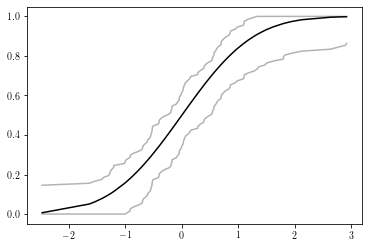

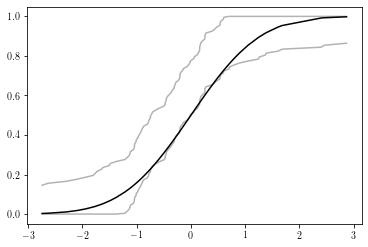

In [61]:
# Bands
def analyze_bands(obs, alpha, distribution, filename):
    epsilon = np.sqrt(1 / (2 * obs.shape[0]) * np.log(2 / alpha))
    uppers = []
    lowers = []
    counts = []
    ecdfs = []
    for i in range(obs.shape[1]):
        ecdf = ECDF(obs[:, i])
        ecdfs.append(ecdf)
        lower = np.zeros(len(ecdf.y))
        upper = np.zeros(len(ecdf.y))
        for j in range(len(ecdf.y)):
            lower[j] = max(ecdf.y[j] - epsilon, 0)
            upper[j] = min(ecdf.y[j] + epsilon, 1)
        
        uppers.append(upper)
        lowers.append(lower)
        count = 0
        for j in range(ecdf.x.size):
            x = ecdf.x[j]
            theo_y = distribution.cdf(x)
            if lower[j] <= theo_y <= upper[j]:
                count += 1
        counts.append(count)
    
    counts = np.array(counts)
    max_index = np.argmax(counts)
    min_index = np.argmin(counts)
    
    # All closed
    num = counts[counts == obs.shape[0]]
    print("Enclosed =", len(num))
    
    # Plotting
    ecdf_max = ecdfs[max_index]
    upper_max = uppers[max_index]
    lower_max = lowers[max_index]
    plt.plot(ecdf_max.x, upper_max, 'k', alpha=0.3)
    plt.plot(ecdf_max.x, lower_max, 'k', alpha=0.3)
    plt.plot(ecdf_max.x, distribution.cdf(ecdf_max.x), 'k')
    plt.savefig(dir_fig("max_" + filename))
    plt.show()
    plt.clf()
    
    ecdf_min = ecdfs[min_index]
    upper_min = uppers[min_index]
    lower_min = lowers[min_index]
    plt.plot(ecdf_min.x, upper_min, 'k', alpha=0.3)
    plt.plot(ecdf_min.x, lower_min, 'k', alpha=0.3)
    plt.plot(ecdf_min.x, distribution.cdf(ecdf_min.x), 'k')
    plt.savefig(dir_fig("min_" + filename))
    plt.show()

analyze_bands(obs, 0.05, st.norm, "normal_bands.pdf")

In [64]:
# Generate cauchy observations
obs_cauchy = st.cauchy.rvs(size=(100, 1000))

Enclosed = 9


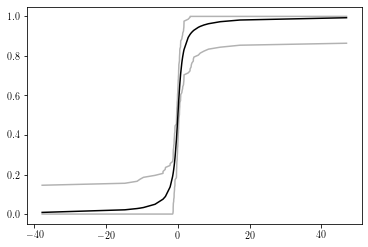

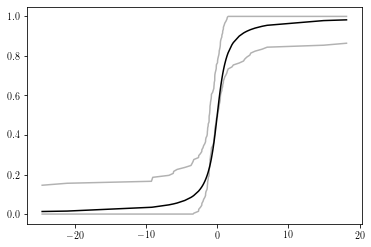

In [65]:
analyze_bands(obs_cauchy, 0.05, st.cauchy, "cauchy_bands.pdf")

In [68]:
lsat = "576 635 558 578 666 580 555 661 651 605 653 575 545 572 594".split(" ")
lsat = list(map(lambda x: int(x), lsat))

gpa = "3.39 3.30 2.81 3.03 3.44 3.07 3.00 3.43 3.36 3.13 3.12 2.74 2.76 2.88 3.96".split(" ")
gpa = list(map(lambda x: float(x), gpa))